# Build Bayesian Classifier

## Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import time
import imutils
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
import skimage.transform as transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate codemap example

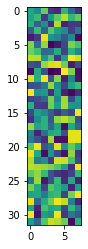

In [3]:
# Codemap size : 32 * 4
size_cm = [32,8]
limit_cm = [0,128]
test_codemap = torch.randint(limit_cm[0], limit_cm[1], (size_cm[0], size_cm[1]))
test_cm_np = test_codemap.numpy().astype(np.uint8)

plt.imshow(test_codemap)

## Resample one element of a codemap (press Enter to exit after selection)

In [4]:
# Init variables
coord_pixel = []

# Mouse function to select the pixel to resample
def select_pixel(event,x,y,flags,param):
    global coord_pixel
    if event == cv2.EVENT_LBUTTONDOWN:
        coord_pixel = [x, y]

# Resample element of codemap
cv2.namedWindow('image')
cv2.setMouseCallback('image', select_pixel)
width = 160
ratio = width / np.shape(test_cm_np)[1]
test_cm_resized =  imutils.resize(test_cm_np, width = width)
while(True):
    cv2.imshow('image', test_cm_resized)
    # Select pixel to resample
    if cv2.waitKey(0) == 13: # press Enter to exit after selection
        break
cv2.destroyAllWindows()

# Display
coord_pixel = (np.floor(np.divide(coord_pixel, ratio))).astype(int)
pixel_x = coord_pixel[0]
pixel_y = coord_pixel[1]
print("Pixel's coordonates : " + str(coord_pixel))
print("Value of the pixel : " + str(test_cm_np[pixel_y][pixel_x]))

Pixel's coordonates : [0 0]
Value of the pixel : 76


In [5]:
# Get the surroundings of the pixel
nb_ngbrs = 2 # number of neighbours to add to the bayesian distribution
ind_max_fr = min(pixel_y + nb_ngbrs + 1, size_cm[0])
ind_min_fr = max(pixel_y - nb_ngbrs, 0)
ind_max_tm = min(pixel_x + nb_ngbrs + 1, size_cm[1])
ind_min_tm = max(pixel_x - nb_ngbrs, 0)
coord_ngbrs = []
values_ngbrs = []

for i in range(ind_min_tm, ind_max_tm):
    for j in range(ind_min_fr, ind_max_fr):
        if abs(i-pixel_x) + abs(j-pixel_y) <= nb_ngbrs and (i!=pixel_x or j!=pixel_y):
            coord_ngbrs.append([i, j])
            values_ngbrs.append(test_cm_np[j][i])

# Init classifier
clf = GaussianNB()
# Fit distribution to the neighbors of pixel
clf.fit(coord_ngbrs, values_ngbrs)
# Predict value
proba_predicted = clf.predict_proba(np.array(coord_pixel).reshape(1, -1))
classes = np.unique(values_ngbrs)
value_predicted = int(round(np.sum(proba_predicted * classes)))

print("Pixel's coordonates : " + str(coord_pixel))
print("Value predicted : " + str(value_predicted))

Pixel's coordonates : [0 0]
Value predicted : 67


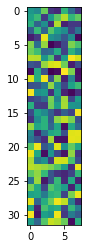

In [6]:
# Resample codemap according to value predicted
codemap_resampled = test_codemap
codemap_resampled[pixel_y][pixel_x] = value_predicted

plt.imshow(codemap_resampled)

# Apply Sampling to MNIST codemaps

## Import MNIST Dataset

In [273]:
# Init MNIST parameters
batch_size_test = 10

In [274]:
# Import test samples
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])),
                    batch_size=batch_size_test, shuffle=True)

In [275]:
# Test on some examples
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
np.shape(example_data)

torch.Size([10, 1, 28, 28])

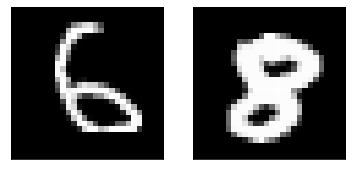

In [276]:
# Display
# Display
for i in range(0,2):
    plt.subplot(1,2,i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Import MNIST Network

In [232]:
class Encoder(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, in_channels*2, 5)
        self.conv2 = nn.Conv2d(in_channels*2, out_channels, 5)
        
        self.activation = nn.ReLU()
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.activation(x)

        return x

In [233]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_codewords, codewords_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self.num_codewords = num_codewords
        self.codewords_dim = codewords_dim
        self.codewords = nn.Parameter(torch.rand(self.num_codewords, self.codewords_dim),requires_grad=True)

        self.commitment_cost = commitment_cost
        
    def forward(self, inputs):
        # Reshape: B, C, H, W -> B*H*W, C
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        flat_inputs = inputs.view(-1, self.codewords_dim)

        # Calculating distances:
        distances = torch.pow(flat_inputs.unsqueeze(1) - self.codewords.unsqueeze(0),2).sum(2)

        # Argmin:
        encoding_indices = torch.argmin(distances, dim=1)

        # Index from dictionary:
        # quantized[i,j] = self.codewords[encoding_indices[i,j], j]
        quantized = torch.gather(self.codewords,0,encoding_indices.unsqueeze(1).expand(-1, self.codewords_dim)).view(inputs.shape)
        encoding_indices = encoding_indices.view(inputs.shape[:-1])

        # quantization loss
        quantizing_loss = F.mse_loss(quantized.detach(), inputs)
        commitment_loss = F.mse_loss(quantized, inputs.detach())
        loss = quantizing_loss + self.commitment_cost * commitment_loss

        # magic trick to copy gradients from inputs
        quantized = inputs + (quantized - inputs).detach()
        
        #Reshape:
        return quantized.permute(0, 3, 1, 2), encoding_indices, loss

In [234]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=5)
        self.conv2 = nn.ConvTranspose2d(in_channels//2, out_channels, kernel_size=5)

        self.activation = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.activation(x)
        x = self.conv2(x)
        return x

In [235]:
class VQVAE(nn.Module):
    def __init__(self,x_dim,z_dim,num_codewords,commitment_cost):
        super().__init__()
        self.encoder = Encoder(x_dim,z_dim)
        self.quantizer = VectorQuantizer(num_codewords, z_dim, commitment_cost)
        self.decoder = Decoder(z_dim, x_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, codes, q_loss = self.quantizer(z_e)
        x_hat = self.decoder(z_q)
        
        return x_hat, codes, q_loss

In [236]:
MNIST_state_dict = torch.load('results/MNIST/model.pth')
MNIST_model = VQVAE(1,16,10,0.15).to(device)
MNIST_model.load_state_dict(MNIST_state_dict)

<All keys matched successfully>

## Simple operations on MNIST Codemaps

In [277]:
example0_encoded = MNIST_model.encoder(example_data).detach()
codemaps, codes, q_loss = MNIST_model.quantizer(example0_encoded)
np.shape(codemaps)

torch.Size([10, 16, 20, 20])

### Downsampling by removing channels

In [278]:
cm_tr = codemaps.clone()
size_cm = np.shape(cm_tr)
for i in range(1,16):
    cm_tr[0][i] = torch.zeros((size_cm[2], size_cm[3]))

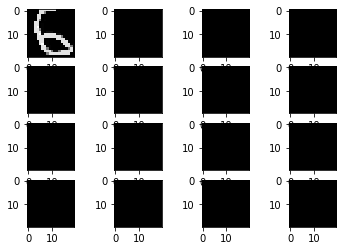

In [279]:
# Display
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(cm_tr[0][i], cmap='gray', interpolation='none')

([], [])

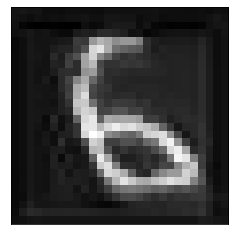

In [280]:
output_tr = MNIST_model.decoder(cm_tr).detach()

plt.imshow(output_tr[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])

### Mix of codemaps

In [281]:
cm_mix = codemaps.clone()
for i in range(8,16):
    cm_mix[0][i] = codemaps[1][i]

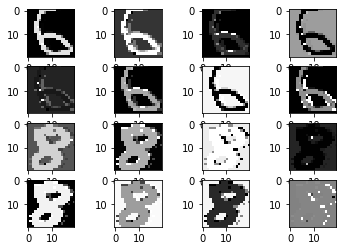

In [282]:
# Display
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(cm_mix[0][i], cmap='gray', interpolation='none')

([], [])

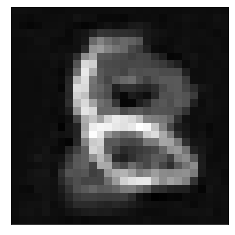

In [283]:
output_mix = MNIST_model.decoder(cm_mix).detach()

plt.imshow(output_mix[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])

## Sampling of MNIST codemaps (press Enter to exit after selection)

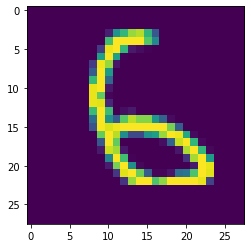

In [284]:
# Example to sample
example_data = example_data.detach()
example0 = (example_data[0][0])
example0_np = example0.numpy()

plt.imshow(example0)

In [285]:
# Function to do inpainting in the defined area
def bayesian_inpainting(data, sample_box, model, nb_ngbrs, autoregressive):
    
    # Get the codemap encoding of the image
    data_copy = data.clone()
    data_encoded = MNIST_model.encoder(data_copy).detach()
    data_quantized, codes, q_loss = MNIST_model.quantizer(data_encoded)
    data_quantized = data_quantized.detach()
    codemap = data_quantized[0]
    size_data = np.shape(data)
    size_data_q = np.shape(data_quantized)

    # Get every element in the sample box
    X_coord, Y_coord = np.mgrid[sample_box[0]:sample_box[0]+sample_box[2], sample_box[1]:sample_box[1]+sample_box[3]]
    XY_coord = np.vstack((X_coord.ravel(), Y_coord.ravel()))
    
    # Do inpainting for each k channel in codemap
    for k in range(0, size_data_q[1]):
        cm = codemap[k]
        cm_resampled = cm.clone()
        
        # Transform codemap to discrete values
        cm_resampled = 10000 * cm_resampled  # Scale by 10000
        cm_resampled = cm_resampled.int()

        # Resampling every element in the box
        for x, y in zip(XY_coord[0], XY_coord[1]):
            # Get the surroundings of the pixel
            ind_max_fr = min(y + nb_ngbrs + 1, size_data_q[2])
            ind_min_fr = max(y - nb_ngbrs, 0)
            ind_max_tm = min(x + nb_ngbrs + 1, size_data_q[3])
            ind_min_tm = max(x - nb_ngbrs, 0)
            coord_ngbrs = []
            values_ngbrs = []
            for i in range(ind_min_tm, ind_max_tm):
                for j in range(ind_min_fr, ind_max_fr):
                    if abs(i-x) + abs(j-y) <= nb_ngbrs and (i!=x or j!=y):
                        coord_ngbrs.append([i, j])
                        if autoregressive:
                            values_ngbrs.append(cm_resampled[j][i])
                        else:
                            values_ngbrs.append(cm[j][i])
            # Init classifier
            clf = GaussianNB()
            # Fit distribution to the neighbors of pixel
            clf.fit(coord_ngbrs, values_ngbrs)
            # Predict value
            proba_predicted = clf.predict_proba(np.array(coord_pixel).reshape(1, -1))
            classes = np.unique(values_ngbrs)
            value_predicted = int(round(np.sum(proba_predicted * classes)))

            # Sample the element selected
            cm_resampled[y][x] = value_predicted
        
        # Transform codemap back to flottant values
        cm_resampled = cm_resampled.float()
        cm_resampled = cm_resampled / 10000
        
        codemap[k] = cm_resampled
    
    # Generate image from resampled codemaps
    data_quantized[0] = codemap
    output = MNIST_model.decoder(data_quantized).detach()

    return output[0][0]

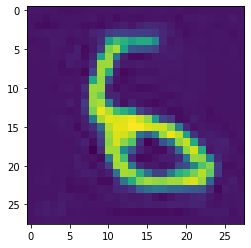

In [289]:
# Get code from example
data_encoded = MNIST_model.encoder(example_data).detach()
data_quantized, codes, q_loss = MNIST_model.quantizer(data_encoded)
codes = codes.detach()
code0 = codes[0] * 255 / 9
code0_np = code0.numpy().astype(np.uint8)

# Adapt image to opencv display
width = 640
ratio = width / np.shape(code0)[1]
code0_resized =  imutils.resize(code0_np, width = width)

# Select ROI
fromCenter = False
selection_box = cv2.selectROI(cv2.cvtColor(code0_resized,cv2.COLOR_GRAY2RGB), fromCenter) # press Enter to exit after selection
cv2.destroyAllWindows()

# Resized box to original size
sample_box = (np.round(np.divide(selection_box, ratio))).astype(int)

# Resampling by inpainting
nb_ngbrs = 2 # number of neighbours to add to the bayesian distribution
autoregressive = True # choose if the sampling method is autoregressive or not
example_resampled = bayesian_inpainting(example_data, sample_box, MNIST_model, nb_ngbrs, autoregressive)

# Display
plt.imshow(example_resampled)

In [290]:
# Display
example_resampled_np = example_resampled.numpy()
example_resampled_resized =  imutils.resize(example_resampled_np, width = width)
while(True):
    cv2.imshow('image', example_resampled_resized)
    # Select pixel to resample
    if cv2.waitKey(0) == 13: # press Enter to exit after selection
        break
cv2.destroyAllWindows()